**Update Jan.2021**, redo the prepare_dataset function, now v3. To keep all data (imbalanced) for training and testing.

Timestamped CNN/RNN, with time limits.


# Colab Setup

In [1]:
# set tensorflow version
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# copy the script file to current folder so it can be imported.
import shutil
import os
original = [
  r'/content/drive/My Drive/time_sequence_alchemy/utils/data_prep.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/model.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/others.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/plot.py',
  r'/content/drive/My Drive/time_sequence_alchemy/log_embeddings_16_sg.txt',
]
target = [
  r'./utils/data_prep.py',
  r'./utils/model.py',
  r'./utils/others.py',
  r'./utils/plot.py',
  r'./log_embeddings_16_sg.txt',
]

if not os.path.exists('./utils'):
  os.makedirs('./utils')

for orig, targ in zip(original, target):
  shutil.copyfile(orig, targ)
  print('Script copied:', targ)


Script copied: ./utils/data_prep.py
Script copied: ./utils/model.py
Script copied: ./utils/others.py
Script copied: ./utils/plot.py
Script copied: ./log_embeddings_16_sg.txt


In [4]:
# data file on Colab
data_fn = r'/content/drive/My Drive/time_sequence_alchemy/data/HDFS/Xy_dataset.pkl'

In [5]:
from utils.data_prep import tokenize, trim_time_sequence, remove_long_sequence, pad_time_sequence
from utils.data_prep import prepare_dataset_v3, oversample_dataset
from utils.model import TimeChanger_FFT, TimeChangerLstm, TimeChanger, naive_evaluate, load_embeddings
from utils.model import ResampleLayer
from utils.others import print_train_info_v2, plot_and_save
from utils import plot
import tensorflow as tf
import numpy as np
import pickle
from time import time
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

# Load Data

In [ ]:
TS_LIMIT = 120  # samples will be trimmed/picked within this limit (sec)
TS_TRIM = TS_LIMIT

# Load data
print('\nLoading data...', end='')
start = time()
with open(data_fn,'rb') as f:
  X, y = pickle.load(f)
print('{:.2f}s'.format(time()-start), end='\t')
print('{:d} samples'.format(len(y)))

# separate value & timestamp
print('\nProcessing data...', end='')
start = time()
x_seq =  X[:, 0]
x_ts = X[:, 1].copy()
# y = y[0:5000]
del X

# tokenization
x_tok, tokenizer = tokenize(x_seq)  # 48 tokens
vocab_size = len(tokenizer.word_counts)
# trim/remove data to a certain time length
x_tok, x_ts, y = remove_long_sequence(x_tok, x_ts, y, TS_LIMIT)  # remove sequence that are longer than limit
trim_time_sequence(x_tok, x_ts, TS_TRIM)  # trim sequence to limit
# front pad data to form matrices.
x_tok, x_ts = pad_time_sequence(x_tok, x_ts, 
    maxlen=250, ts_interval=0.1)

print('{:.2f}s'.format(time()-start), end='\t')
print('{:d} samples, {:d} samples with label=1.'.format(len(y), sum(y)))


Loading data...40.93s	575061 samples

Processing data...47.24s	101245 samples, 6422 samples with label=1.


## Load embeddings
Load the word2vec results. For token 0 (placeholder), set embedding to all 0.

In [ ]:
embeddings, embedding_dims = load_embeddings('./log_embeddings_16_sg.txt')
# obtain token - embedding matrix, token zero's embedding is zero.
embedding_matrix = np.zeros((vocab_size+1, embedding_dims))

for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = embeddings[word]

print(embedding_matrix.shape)

vocab_size, embedding_dims: 48 16
(49, 16)


## Make dataset

In [ ]:
# make dataset
test_ratio = 0.2
val_ratio = 0.2

# Dataset split
_train, _val, _test = prepare_dataset_v3(x_tok, x_ts, y, test_ratio=test_ratio, val_ratio=val_ratio)
x_train, ts_train, y_train = _train
x_val, ts_val, y_val = _val
x_test, ts_test, y_test = _test
train_size, val_size, test_size = [len(y_train), len(y_val), len(y_test)]
# del _train, _val, _test

print('Available data samples:', len(y_train)+len(y_val)+len(y_test), end=', \t')
print('train:{}, val:{}, test:{}\n'.format(train_size, val_size, test_size))

# balance training dataset (oversampling)
x_train, ts_train, y_train = oversample_dataset(x_train, ts_train, y_train)
train_size = len(x_train)

# checksum
print('After balancing the training dataset,', end='\t')
print('train:{}, val:{}, test:{}\n'.format(train_size, val_size, test_size))

print('Check the first 20 labels of each dataset are consistent:')
print(y_train[0:20], '\n', y_val[0:20], '\n', y_test[0:20], '\n')

Available data samples: 101245, 	train:64796, val:16200, test:20249

After balancing the training dataset,	train:121372, val:16200, test:20249

Check the first 20 labels of each dataset are consistent:
[0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0] 
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 



Check the dataset split is consistent. The first 20 items should be:

120s data
- ```train: [0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0]```
- ```val__: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]```
- ```test_: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]```

In [ ]:
# make tensorflow style dataset for manual training
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, ts_train, y_train)).batch(batch_size).prefetch(2)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, ts_val, y_val)).batch(batch_size).prefetch(2)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, ts_test, y_test)).batch(batch_size).prefetch(2)

# ZOH interp
seems simple, just modify a line

In [ ]:
from utils.model import tensor_interp, tensor_interp3d

In [ ]:
class ResampleLayer(tf.keras.layers.Layer):
    '''Resample the input signal (value, ts) into evenly spaced samples using 
    ZOH or linear method.
    Throw away timestamps.
    
    Parameters
    ----------
    duration: the time duration of resampled signal, in integer seconds.
    resolution: the resolution of resampled signal, in float seconds.
    method: 'linear' or 'zoh', default 'linear'.

    '''
    def __init__(self, duration=100, resolution=0.1, method='linear'):
        super(ResampleLayer, self).__init__()
        self.res = resolution      # resolution, in seconds
        self.duration = duration   # length, in seconds
        self.out_length = int(duration/resolution) + 1   # length of signal, unitless
        self.method = method
        
    # def build(self, input_shape):
    
    def call(self, batch_in):
    
        embed_batch, ts_batch = batch_in

        # embed_batch.shape: (batch_size, seq_length, embed_dims)
        # ts_batch.shape: (batch_size, seq_length)
        assert len(embed_batch.shape) == 3, 'input data should be 3 dims.'
        batch_size = embed_batch.shape[0]
        seq_length = embed_batch.shape[1]
        embed_dims = embed_batch.shape[2]
        
        # reference timestamps
        ts_new = tf.linspace(0., self.duration, num=self.out_length)
        ts_new = tf.expand_dims(ts_new, axis=0)
        ts_new = tf.expand_dims(ts_new, axis=0)
        ts_new = tf.tile(ts_new, tf.TensorShape([batch_size,embed_dims,1])) # (batch_size,embed_dims,new_length)
        
        # adjust the dimensions of inputs
        ts_batch = tf.expand_dims(ts_batch, axis=1)  # (batch_size,1,seq_length)
        ts_batch = tf.tile(ts_batch, [1,embed_dims,1]) # (batch_size,embed_dims,seq_length)
        embed_batch = tf.transpose(embed_batch, perm=[0,2,1]) # (batch_size,embed_dims,seq_length)

        # iterate through each sample.
        if self.method == 'linear':
            batch_out = tensor_interp3d(ts_new, ts_batch, embed_batch)
        elif self.method == 'zoh':
            batch_out = tensor_interp(ts_new, ts_batch, embed_batch, method='zoh')
        else:
            print('Argument error')
            raise
        
        return tf.transpose(tf.stack(batch_out,axis=0), perm=(0,2,1)) # (batch_size, seq_length, embed_dims)


# Models with timestamps

## ZOH model


In [ ]:
class TimeChangerCnn(tf.keras.Model):
  def __init__(self, vocab_size, embedding_matrix):
    super().__init__()
    
    embedding_dims = 16
    self.embed = tf.keras.layers.Embedding(
      vocab_size+1, embedding_dims,     # +1 because of padding 0
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
      trainable=False, input_length=250)  # input_length=input_length)
    max_duration = TS_TRIM # seconds
    resolution = 0.1   # seconds
    self.resample = ResampleLayer(max_duration, resolution, method='zoh')   # <==== changed here
    self.cnn_model = tf.keras.models.Sequential([
      # tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
      tf.keras.layers.Conv1D(filters=32, kernel_size=8, strides=3),
      # tf.keras.layers.MaxPool1D(pool_size=2),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
      tf.keras.layers.GlobalMaxPool1D(),
      #tf.keras.layers.MaxPool1D(pool_size=2),
      #tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1, activation='sigmoid'),
    ])
    
  #@tf.function
  def call(self, data):
    in_seq, ts_seq = data
    in_seq = self.embed(in_seq)
    output = self.resample((in_seq, ts_seq))
    output = self.cnn_model(output)
    return output

model_zoh = TimeChangerCnn(vocab_size, embedding_matrix)
model_zoh((x_tok[0:2], x_ts[0:2]))
model_zoh.summary()

Model: "time_changer_cnn_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      multiple                  784       
_________________________________________________________________
resample_layer_7 (ResampleLa multiple                  0         
_________________________________________________________________
sequential_9 (Sequential)    (2, 1)                    6273      
Total params: 7,057
Trainable params: 6,273
Non-trainable params: 784
_________________________________________________________________


## Linear model


In [ ]:
class TimeChangerCnn1(tf.keras.Model):
  def __init__(self, vocab_size, embedding_matrix):
    super().__init__()
    
    embedding_dims = 16
    self.embed = tf.keras.layers.Embedding(
      vocab_size+1, embedding_dims,     # +1 because of padding 0
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
      trainable=False, input_length=250)  # input_length=input_length)
    max_duration = TS_TRIM # seconds
    resolution = 0.1   # seconds
    self.resample = ResampleLayer(max_duration, resolution)   # <==== changed here
    self.cnn_model = tf.keras.models.Sequential([
      # tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
      tf.keras.layers.Conv1D(filters=32, kernel_size=8, strides=3),
      # tf.keras.layers.MaxPool1D(pool_size=2),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
      tf.keras.layers.GlobalMaxPool1D(),
      #tf.keras.layers.MaxPool1D(pool_size=2),
      #tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1, activation='sigmoid'),
    ])
    
  #@tf.function
  def call(self, data):
    in_seq, ts_seq = data
    in_seq = self.embed(in_seq)
    output = self.resample((in_seq, ts_seq))
    output = self.cnn_model(output)
    return output

model_lin = TimeChangerCnn1(vocab_size, embedding_matrix)
model_lin((x_tok[0:2], x_ts[0:2]))
model_lin.summary()

Model: "time_changer_cnn1_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  784       
_________________________________________________________________
resample_layer_8 (ResampleLa multiple                  0         
_________________________________________________________________
sequential_10 (Sequential)   (2, 1)                    6273      
Total params: 7,057
Trainable params: 6,273
Non-trainable params: 784
_________________________________________________________________


## Examine model

In [ ]:
# which dimension to display 
n = 1
dim = 1
ts_new = np.linspace(0,120, 1201)  # the horizontal axis for resampled plot


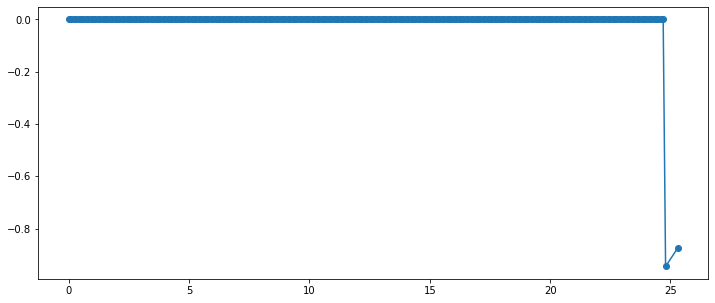

In [ ]:
# The original timestamp sequence
act_embed = model_zoh.layers[0](x_tok[0:2])
act_interp = model_zoh.layers[1]((act1, x_ts[0:2]))

plt.figure(figsize=(12,5))
plt.plot(x_ts[n], act_embed[n,:,dim], '-o')

(20.0, 30.0)

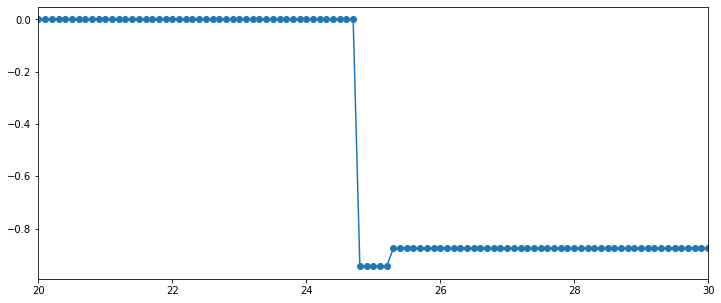

In [ ]:
# The resampled timestamp sequence
act_embed = model_zoh.layers[0](x_tok[0:2])
act_interp = model_zoh.layers[1]((act1, x_ts[0:2]))

plt.figure(figsize=(12,5))
plt.plot(ts_new, act_interp[n,:,dim], '-o')
plt.xlim([20,30])

(20.0, 30.0)

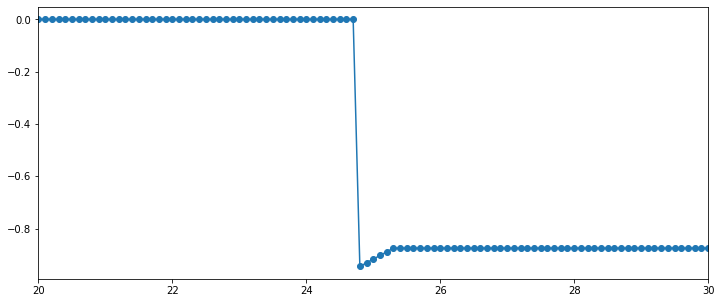

In [ ]:
# The resampled timestamp sequence, linear model
act_embed = model_lin.layers[0](x_tok[0:2])
act_interp = model_lin.layers[1]((act1, x_ts[0:2]))

plt.figure(figsize=(12,5))
plt.plot(ts_new, act_interp[n,:,dim], '-o')
plt.xlim([20,30])